In [ ]:
!git clone https://github.com/ahnchive/SB-SAT.git

fatal: destination path 'SB-SAT' already exists and is not an empty directory.


In [ ]:
import os
import pandas as pd
import numpy as np
import json
import h5py
import pathlib
import pickle
from collections import defaultdict
import random
from copy import deepcopy
from datetime import datetime

from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import itertools

from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, LSTM, GRU, RNN, CuDNNGRU, CuDNNLSTM, Bidirectional
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras import backend as K
from keras import regularizers

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.debugger import set_trace

In [ ]:
datanorm = True
datacols = ['CURRENT_FIX_X', 'CURRENT_FIX_Y', 'CURRENT_FIX_PUPIL', 'CURRENT_FIX_DURATION']

delta = 10
step =  2*delta+1

datasplit = 'subject'

labelcols = ['subj', 'book',
            'acc_level', 'subj_acc_level', 
            'confidence', 'difficulty', 'familiarity', 'recognition', 
            'interest', 'pressured', 'sleepiness', 'sleephours',
            'sex', 'native']

pred_variable = 'subj_acc_level'

modeltype = 'cnn'

BATCH_SIZE = 100
EPOCHS = 1000

In [ ]:
sc = pd.read_csv('SB-SAT/fixation/18sat_labels.csv')

sc = sc[labelcols]

sc['sex'] = sc['sex'].replace(['F', 'M'], [1,0])
binarycols = ('recognition', 'sex', 'native')
subsetcols = [c for c in labelcols if c not in binarycols]
sc[subsetcols] = sc[subsetcols].replace([0,1,2,3], [0,0,1,1])

for column in sc:
    print(sc[column].value_counts(sort=False, dropna=False), '\n')

msd001    4
msd002    4
msd003    4
msd004    4
msd005    4
         ..
msd102    4
msd103    4
msd105    4
msd106    4
msd107    4
Name: subj, Length: 95, dtype: int64 

dickens      95
flytrap      95
genome       95
northpole    95
Name: book, dtype: int64 

1    231
0    149
Name: acc_level, dtype: int64 

1    180
0    200
Name: subj_acc_level, dtype: int64 

1    161
0    219
Name: confidence, dtype: int64 

0    252
1    128
Name: difficulty, dtype: int64 

0    291
1     89
Name: familiarity, dtype: int64 

0    373
1      7
Name: recognition, dtype: int64 

1    230
0    150
Name: interest, dtype: int64 

0    250
1    130
Name: pressured, dtype: int64 

0    233
1    147
Name: sleepiness, dtype: int64 

1    200
0    180
Name: sleephours, dtype: int64 

1    252
0    128
Name: sex, dtype: int64 

1    264
0    116
Name: native, dtype: int64 



In [ ]:
def group_windows(fixationRows):
    windows = []
    fixationRows.reset_index(inplace=True)  
    for n in range(delta, len(fixationRows)-delta, step):
        window = fixationRows.loc[n-delta:n+delta,datacols].values.tolist()
        windows.append(window)
    return windows
def generate_windata(fixation):
    subjectPool = pd.unique(fixation['RECORDING_SESSION_LABEL'])
    pagePool = pd.unique(fixation['page_name'])
    windowData = {}
    for subject in subjectPool:
        subjectRows = fixation.loc[fixation['RECORDING_SESSION_LABEL'] == subject]
        windowData[subject] = {}
        print("\rprocessing Subject: " + subject, end='')
        for page in pagePool:
            pageRows = subjectRows.loc[subjectRows['page_name'] == page]
            windows = group_windows(pageRows)
            windowData[subject][page] = windows
    print ("\nwindow data ready")
    return windowData
def create_dataset(windowData, sc):
    dataset = []
    index= []
    labeldf = pd.DataFrame()
    for subject in windowData:
        for article in windowData[subject]:
            windows = windowData[subject][article]
            for window in windows:
                dataset.append(window)
                book = article.split('-')[1]
                row = sc[(sc['subj'] == subject) & (sc['book'] == book)]
                labeldf = pd.concat([labeldf, row])
    
    print('dataset created')
    return np.array(dataset), labeldf  

In [ ]:
fd = pd.read_csv('SB-SAT/fixation/18sat_fixfinal.csv')
fd_rd = fd.loc[fd.type == 'reading']
if datanorm:
    fixData = fd_rd.copy(deep=True)
    fixData[datacols] = (fd_rd[datacols]-fd_rd[datacols].min())/(fd_rd[datacols].max()-fd_rd[datacols].min())
else:
    fixData = fd_rd.copy(deep=True)
fixData[datacols].describe()
windowData = generate_windata(fixData)

processing Subject: msd107
window data ready


In [ ]:
with open('windowData_'+str(delta)+'.pkl', 'wb') as fp:
    pickle.dump(windowData, fp)

In [ ]:
datasplit = 'book'

if datasplit == 'subject':
    subjkeys = list(windowData.keys())
    random.Random(23).shuffle(subjkeys)
    N_totalsub = len(subjkeys)
    N_trainsub = round(0.6*N_totalsub)
    N_validsub = round(0.2*N_totalsub)
    N_testsub = N_totalsub - N_trainsub - N_validsub

    windowData_train = deepcopy(windowData)
    windowData_valid = {}
    windowData_test = {}

    for i, subj in enumerate(subjkeys):
        if i in range(N_validsub):
            windowData_valid[subj] = windowData_train[subj]
            del windowData_train[subj]
        elif i in range(N_validsub, N_validsub + N_testsub):
            windowData_test[subj] = windowData_train[subj]
            del windowData_train[subj]

    print("train subj #", len(list(windowData_train.keys())))
    print("valid subj #", len(list(windowData_valid.keys())))
    print("test subj #", len(list(windowData_test.keys())))

    X_train, labels_train = create_dataset(windowData_train, sc)
    X_valid, labels_valid = create_dataset(windowData_valid, sc)
    X_test, labels_test = create_dataset(windowData_test, sc)
elif datasplit == 'record':
    X, labels = create_dataset(windowData, sc)
    X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.4, random_state=23)
    X_valid, X_test, labels_valid, labels_test = train_test_split(X_test, labels_test, test_size=0.5, random_state=23)

elif datasplit == 'book':
    subjkeys = list(windowData.keys())
    pagekeys = list(windowData[subjkeys[0]].keys())
    bookkeys = list(np.unique(sc['book']))
    print('list of books:', bookkeys)

    windowData_train = deepcopy(windowData)
    windowData_valid = defaultdict(dict)
    windowData_test = defaultdict(dict)

    for subj in subjkeys:
        tmp = random.sample(bookkeys,2)
        for page in pagekeys:
            if (page.split('-')[1] == tmp[0]):
                windowData_valid[subj][page] = windowData_train[subj][page]
                del windowData_train[subj][page]
                
            elif (page.split('-')[1] == tmp[1]): 
                windowData_test[subj][page] = windowData_train[subj][page]
                del windowData_train[subj][page]

    X_train, labels_train = create_dataset(windowData_train, sc)
    X_valid, labels_valid = create_dataset(windowData_valid, sc)
    X_test, labels_test = create_dataset(windowData_test, sc)

    print("train book #", list(windowData_train['msd001'].keys()))
    print("valid book #", list(windowData_valid['msd001'].keys()))
    print("test book #", list(windowData_test['msd001'].keys()))

list of books: ['dickens', 'flytrap', 'genome', 'northpole']
dataset created
dataset created
dataset created
train book # ['reading-dickens-1', 'reading-dickens-2', 'reading-dickens-3', 'reading-dickens-4', 'reading-dickens-5', 'reading-flytrap-1', 'reading-flytrap-2', 'reading-flytrap-3', 'reading-flytrap-4', 'reading-flytrap-5', 'reading-flytrap-6']
valid book # ['reading-genome-1', 'reading-genome-2', 'reading-genome-3', 'reading-genome-4', 'reading-genome-5', 'reading-genome-6']
test book # ['reading-northpole-1', 'reading-northpole-2', 'reading-northpole-3', 'reading-northpole-4', 'reading-northpole-5']


In [ ]:
np.save('SB-SAT/model/dataset/'+ datasplit +'wise/train/fix_train_' + str(delta) + '.npy', X_train)
np.save('SB-SAT/model/dataset/' + datasplit + 'wise/val/fix_valid_' + str(delta) + '.npy', X_valid)
np.save('SB-SAT/model/dataset/'+ datasplit + 'wise/test/fix_test_' + str(delta) + '.npy', X_test)

labels_train.to_csv('SB-SAT/model/dataset/'+ datasplit +'wise/train/label_train_' + str(delta)+ '.csv', index=False)
labels_valid.to_csv('SB-SAT/model/dataset/'+ datasplit +'wise/val/label_train_' + str(delta) + '.csv', index=False)
labels_test.to_csv('SB-SAT/model/dataset/'+ datasplit + 'wise/test/label_train_' + str(delta) + '.csv', index=False)

In [ ]:
X_train = np.load('SB-SAT/model/dataset/'+ datasplit +'wise/train/fix_train_' + str(delta) + '.npy')
X_valid = np.load('SB-SAT/model/dataset/' + datasplit + 'wise/val/fix_valid_' + str(delta) + '.npy')
X_test = np.load('SB-SAT/model/dataset/'+ datasplit + 'wise/test/fix_test_' + str(delta) + '.npy')

labels_train = pd.read_csv('SB-SAT/model/dataset/'+ datasplit +'wise/train/label_train_' + str(delta)+ '.csv')
labels_valid = pd.read_csv('SB-SAT/model/dataset/'+ datasplit +'wise/val/label_train_' + str(delta) + '.csv')
labels_test = pd.read_csv('SB-SAT/model/dataset/'+ datasplit + 'wise/test/label_train_' + str(delta) + '.csv')

In [ ]:
pred_variable = 'difficulty'

if pred_variable == 'subj':
    y_train = labels_train[pred_variable].astype('category').cat.codes
    y_valid = labels_valid[pred_variable].astype('category').cat.codes
    y_test = labels_test[pred_variable].astype('category').cat.codes

else:
    y_train = labels_train[pred_variable]
    y_valid = labels_valid[pred_variable]
    y_test = labels_test[pred_variable]
num_classes = len(pd.unique(y_train))

print("##### data description #####")
print("# of classes:\t",num_classes)

input_shape = X_train.shape[1:]
print("input shape is:\t",input_shape)

N_samples_train = X_train.shape[0]
print("# of samples for training is:\t", N_samples_train)

N_samples_valid = X_valid.shape[0]
print("# of samples for validation is:\t", N_samples_valid)

N_samples_test = X_test.shape[0]
print("# of samples for prediction is:\t", N_samples_test)

N_total = N_samples_train + N_samples_valid + N_samples_test
print("# of total sampels:\t", N_total)

weights = class_weight.compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)

print("\n##### data imbalances #####")
print(y_train.value_counts(normalize=True).sort_index())

print("\n##### loss weight #####")
weights = dict(enumerate(weights))
print(weights)

print("\n##### null acc for test dataset #####")
print(np.max(y_test.value_counts(normalize=True).sort_index()))

y_train = np_utils.to_categorical(y_train, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)


##### data description #####
# of classes:	 2
input shape is:	 (21, 4)
# of samples for training is:	 5854
# of samples for validation is:	 2881
# of samples for prediction is:	 2813
# of total sampels:	 11548

##### data imbalances #####
0    0.671336
1    0.328664
Name: difficulty, dtype: float64

##### loss weight #####
{0: 0.7447837150127227, 1: 1.5213097713097714}

##### null acc for test dataset #####
0.6761464628510487


In [ ]:
modeltype = 'rnn'

if 'model' in globals():
    del model
    K.clear_session()

if modeltype == 'linear':
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.summary()

elif modeltype == 'cnn':
    model = Sequential()

    model.add(Conv1D(40, 3, input_shape= input_shape))
    model.add(Activation('relu'))
    model.add(Conv1D(40, 3))
    model.add(Activation('relu'))
    model.add(Conv1D(40, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))

    model.add(Flatten())

    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(20))
    model.add(Activation('relu'))

    model.add(Dense(num_classes, activation='softmax'))

    print(model.summary())

elif modeltype == 'rnn':
    model = Sequential()

    model.add(Bidirectional(LSTM(25, return_sequences = True),input_shape=input_shape)) 
    model.add(Bidirectional(LSTM(25)))
    model.add(Dropout(0.3))

    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(20))
    model.add(Activation('relu'))

    model.add(Dense(num_classes, activation='softmax'))
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 21, 50)           6000      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50)               15200     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 dropout_1 (Dropout)         (None, 50)                0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

date_time = datetime.now()
d = date_time.strftime("%m%d%H%M")
print(d)

callbacks_list = [
    ModelCheckpoint(
        filepath= '../checkpoint/' + str(d) +'-{epoch:02d}-{val_accuracy:.2f}.h5',
        monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=50)
]

hist = model.fit(X_train, y_train, batch_size=BATCH_SIZE,  epochs =EPOCHS, class_weight = weights, verbose=2, callbacks=callbacks_list,  validation_data= (X_valid, y_valid), shuffle=True)

01051533
Epoch 1/1000
59/59 - 13s - loss: 0.6709 - accuracy: 0.6131 - val_loss: 0.7667 - val_accuracy: 0.4509 - 13s/epoch - 228ms/step
Epoch 2/1000
59/59 - 3s - loss: 0.6703 - accuracy: 0.6074 - val_loss: 0.7717 - val_accuracy: 0.5804 - 3s/epoch - 44ms/step
Epoch 3/1000
59/59 - 3s - loss: 0.6747 - accuracy: 0.5977 - val_loss: 0.7317 - val_accuracy: 0.5429 - 3s/epoch - 43ms/step
Epoch 4/1000
59/59 - 2s - loss: 0.6697 - accuracy: 0.6057 - val_loss: 0.7326 - val_accuracy: 0.5484 - 2s/epoch - 42ms/step
Epoch 5/1000
59/59 - 2s - loss: 0.6692 - accuracy: 0.6068 - val_loss: 0.7573 - val_accuracy: 0.4748 - 2s/epoch - 42ms/step
Epoch 6/1000
59/59 - 3s - loss: 0.6699 - accuracy: 0.6194 - val_loss: 0.7507 - val_accuracy: 0.5456 - 3s/epoch - 43ms/step
Epoch 7/1000
59/59 - 2s - loss: 0.6673 - accuracy: 0.6218 - val_loss: 0.7376 - val_accuracy: 0.4932 - 2s/epoch - 42ms/step
Epoch 8/1000
59/59 - 2s - loss: 0.6691 - accuracy: 0.6184 - val_loss: 0.7305 - val_accuracy: 0.5630 - 2s/epoch - 42ms/step
Epoc

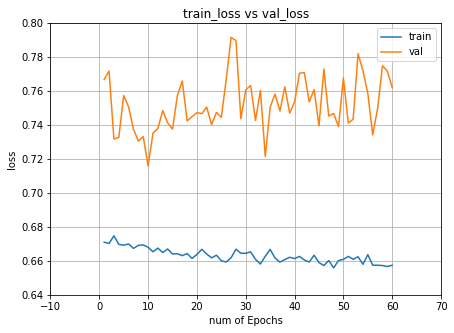

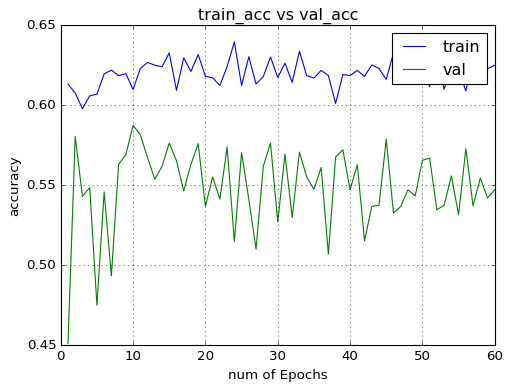

In [ ]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(1,len(train_loss)+1)

plt.figure(1, figsize=(7, 5), facecolor="white")
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train', 'val'])
plt.style.use(['classic'])

plt.figure(2, figsize=(7, 5),facecolor="white")
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train', 'val'])
plt.style.use(['classic'])

In [ ]:
from keras.models import load_model

!mkdir -p saved_model
model.save('savedmodel/'+ pred_variable + '/' + datasplit+ 'wise/' + modeltype + '.h5')

file_model = 'savedmodel/'+ pred_variable + '/' + datasplit+ 'wise/' + modeltype + '.h5'
loaded_model = load_model(file_model)
print("Loaded model from disk")

Loaded model from disk


In [ ]:
print("predicted variable:", pred_variable, '\n')

score = loaded_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Y_pred = loaded_model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

target_names = ['level {}'.format(i) for i in range(num_classes)]

print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
print("confusion matrix: \n", confusion_matrix(np.argmax(y_test, axis=1), y_pred))

print("Balanced acc score:", balanced_accuracy_score(np.argmax(y_test, axis=1), y_pred))
print("Balanced error rate:", 1- balanced_accuracy_score(np.argmax(y_test, axis=1), y_pred))

predicted variable: difficulty 

Test Loss: 0.7693098187446594
Test accuracy: 0.5687877535820007
88/88 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

     level 0       0.70      0.63      0.67      1902
     level 1       0.36      0.43      0.39       911

    accuracy                           0.57      2813
   macro avg       0.53      0.53      0.53      2813
weighted avg       0.59      0.57      0.58      2813

confusion matrix: 
 [[1205  697]
 [ 516  395]]
Balanced acc score: 0.5335665502025138
Balanced error rate: 0.46643344979748624


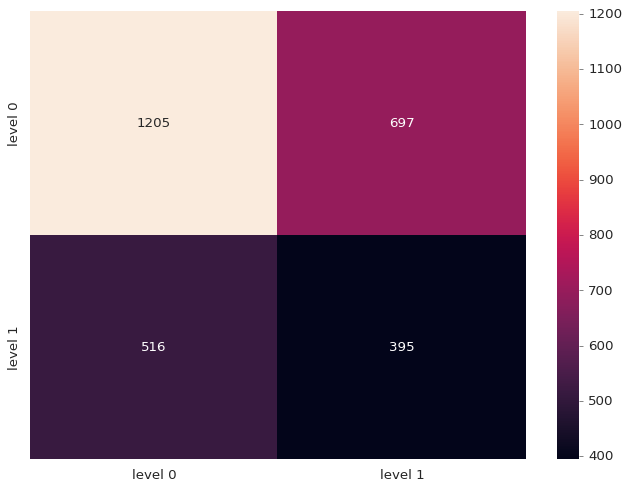

In [ ]:
sns.set_style("white")
cfmtrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

df_cm = pd.DataFrame(cfmtrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt="d")